# Import libraries

In [115]:
#!pip3 install linformer pytorch-lightning

from __future__ import print_function

import glob
from itertools import chain
import os
import random
import pprint
import zipfile
import tqdm
import glob
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

from vit_pytorch.efficient import ViT
from vit_pytorch.deepvit import DeepViT

# Captum packages
from captum.attr import *

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

In [51]:
print(f"Torch: {torch.__version__}")

Torch: 1.11.0


# Set seeds

In [52]:
# Training settings
batch_size = 64
epochs = 25
lr = 3e-5
gamma = 0.7
seed = 42

In [53]:
def seed_allenv(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_allenv(seed)

In [54]:
device = 'cuda'


## Load and prepare data

In [55]:
PATH = "../reproducibility/acm_full_pdfs/pdfs_to_imgs/"
#%mkdir ../reproducibility/acm_full_pdfs/abstractImgs

PATHabstract = "../reproducibility/acm_full_pdfs/abstractImgs/"
PATHabstract = "../reproducibility/acm_full_pdfs/pdfs_figures/images/"

## Prepare df Labels

In [56]:
#Load the labels in a dataframe
dfLabels = pd.read_csv("../data_make/labelData.csv").drop(columns="Unnamed: 0")
dfLabels.head()
dfLabels.columns

# Use this to set the artifacts available column to zero wherever there are multiple labels
dfLabels.loc[list(dfLabels[dfLabels.sum(axis=1)>1].index),'Artifacts Available'] =  0

# Use this to combine 'Best Artifact', 'Best Industry Paper', 'Best Paper', 'Best Student Paper','Distinguished Paper'
accolades = ['Best Artifact', 'Best Industry Paper', 'Best Paper', 'Best Student Paper','Distinguished Paper']
dfLabels['Awards'] = dfLabels[accolades].sum(axis=1)
#dfLabels.where(dfLabels > 1, 1, inplace=True)
assert dfLabels[dfLabels['Awards']>1].shape[0]==0,"Some papers have multiple awards, please set them to 1"
dfLabels.drop(columns = accolades, inplace=True)
dfLabels.sum()

/tmp/ipykernel_8743/863216770.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfLabels.loc[list(dfLabels[dfLabels.sum(axis=1)>1].index),'Artifacts Available'] =  0


fileName                            198429.1984333368089.34097552701.356110ICSE.20...
Artifacts Available                                                               191
Artifacts Evaluated & Functional                                                  348
Artifacts Evaluated & Reusable                                                    655
Results Reproduced                                                                169
Awards                                                                             33
dtype: object

In [8]:
# mkdir ../reproducibility/acm_full_pdfs/abstractImgs/

In [9]:
# train_dir = 'data/train'
# test_dir = 'data/test'

## Already copied

In [10]:
# For copying first page from PATH to PATHabstract directory
for imgP in glob.glob(os.path.join(PATH, "*_0*")):
    fileName = "".join(imgP.split("_0")).split("/")[-1].strip(".png")
    print(fileName)
    if fileName in dfLabels.fileName.values:
        shutil.copy(imgP, os.path.join(PATHabstract, fileName +'.png'))    
    clear_output(wait=True)

3213232.3213235


## Train test splits

In [31]:
train_list = glob.glob(os.path.join(PATHabstract,'*.png'))#[:5500]
test_list = glob.glob(os.path.join(PATHabstract, '*.png'))

In [32]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
train_fileNames = [tl.strip(".png").split("/")[-1] for tl in train_list]

Train Data: 7567
Test Data: 7567


In [33]:
labels = train_fileNames

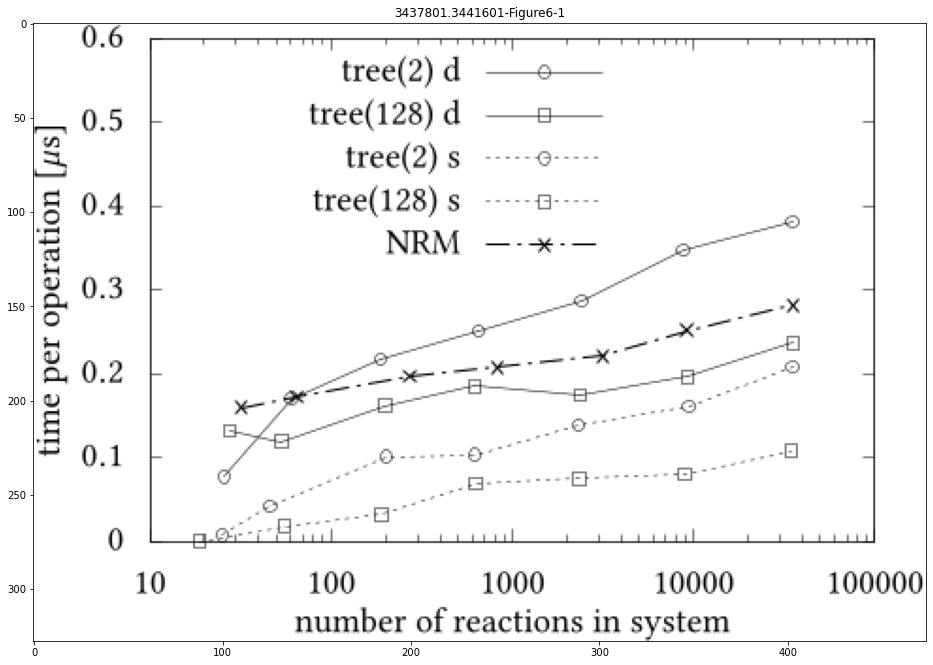

In [36]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(1, 1, figsize=(16, 12))
idx=111
#for idx, ax in enumerate(axes):
img = Image.open(train_list[idx])
axes.set_title(labels[0])
axes.imshow(img)

In [37]:
train_list, test_list = train_test_split(train_list, 
                                          test_size=0.3,
                                          random_state=seed)

test_list, valid_list = train_test_split(test_list, 
                                          test_size=0.5,
                                          random_state=seed)

In [38]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 5296
Validation Data: 1136
Test Data: 1135


In [39]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [40]:

class reproduceDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        # label = img_path.split("/")[-1].split(".")[0]
        # label = 1 if label == "dog" else 0
        #fileName = img_path.strip(".png").split("/")[-1]
        
        fileName = img_path.strip(".png").split("/")[-1].split("-")[0]
        # print(fileName)
        
        #label=dfLabels[dfLabels["fileName"]==fileName].drop(columns = "fileName").values
        label=dfLabels[dfLabels["fileName"]==fileName].drop(columns = "fileName").values
        # print(label)
        return img_transformed, label

In [41]:
train_data = reproduceDataset(train_list, transform=train_transforms)
valid_data = reproduceDataset(valid_list, transform=test_transforms)
test_data = reproduceDataset(test_list, transform=test_transforms)

In [42]:
# 
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [43]:
# for data, label in test_loader:
#     print(label.detach().numpy().shape)

## Evaluation function

In [169]:

'''
Function to compute the accuracy given  the output and the ground truth

Parameters:
----------

output_fn : a batch of output labels

label_fn : a batch of input labels

Returns:
------
metrics : a dict with all accuracy, precision, recall

'''
import tqdm
def compute_metrics(datasetLoader=[], criterion=[], model=[], typeD="full"):
    
    assert datasetLoader!=[] or model!=[], "Inconsistent arguments"
    
    metrics = {"accuracy" : [],
              "precision" : [],
              "recall" : [],
              "f1score": [],
              "loss" : []}
    
    with torch.no_grad():
        # print("Evaluation in progress for type : {}".format(typeD))
        for data, label in datasetLoader:
            #print(data.shape)
            #print(label.shape)
            output = model(data)

            if not isinstance(criterion, list):
                loss = criterion(output, label)

            output = output.detach().numpy()
            label = label.detach().numpy().squeeze()
            metrics = __get_metrics(output, label, metrics)
        
    return {key : np.mean(val) for key, val in metrics.items()}
    
def __get_metrics(output, label, metrics):
    for i in range(5):    
        # take the outss
        # print(output)
        outputSlice = np.take(output,i, axis=1)>0.5#.shape
        # print(outputSlice)
        outputSlice = outputSlice.astype(int)
        # print("Sum of output slice : {}".format(np.sum(outputSlice)))
        labelSlice = np.take(label,i, axis=1)

        if outputSlice.shape!=labelSlice.shape:
            print("outputSlice and inputSlice \
                  do not match os : {} . is {}".format(outputSlice.shape, inputSlice.shape))

        outputSlice = outputSlice[:len(labelSlice)]

        assert len(outputSlice)==len(labelSlice), "There is a mismatch in the label and output sequence lengths"
        with np.errstate(divide='ignore', invalid='ignore'):
            metrics["accuracy"].append(accuracy_score(labelSlice, outputSlice))
            metrics["precision"].append(precision_score(labelSlice, outputSlice, average = 'weighted',zero_division=0))
            metrics["recall"].append(recall_score(labelSlice, outputSlice, average = 'weighted',zero_division=0))
            metrics["f1score"].append(f1_score(labelSlice, outputSlice, average = 'weighted',zero_division=0))
            
        if not isinstance(criterion, list):
            metrics["loss"].append(f1_score(labelSlice, outputSlice, average = 'weighted'))

    return metrics
#{key : np.mean(val) for key, val in metrics.items()}

In [122]:
precision_score([1,0,0,0],[0,0,0,0], average="weighted")

0.5625

## Custom model definition 

In [58]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 60, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(60, 100, 5)
        self.conv3 = nn.Conv2d(100, 30, 5)
        self.fc1 = nn.Linear(17280, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Load trained custom model

In [77]:
net = Net()
net.load_state_dict(torch.load('custom'))
net.eval()

Net(
  (conv1): Conv2d(3, 60, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(100, 30, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=17280, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

## Train custom model 

In [110]:

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# loss function
# Training settings
batch_size = 64
epochs = 25
lr = 3e-2
gamma = 0.7
seed = 42

criterion = nn.MultiLabelSoftMarginLoss()
# optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs.shape)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
        if i % 5 == 0:    # print every 2 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
            running_loss = 0.0
        
#         if i % 5 == 0:    # print every 2 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
#             running_loss = 0.0
        
    clear_output(wait=True)
    print("Validation metrics for epoch : {}".format(epoch))
    pprint.pprint(compute_metrics(valid_loader, criterion,net))
    print()
    print("Train metrics for epoch : {}".format(epoch))
    pprint.pprint(compute_metrics(train_loader, criterion,net))
    print()
print('Finished Training')

Validation metrics for epoch : 9
{'accuracie': 0.7317129629629628,
 'f1score': 0.7317129629629628,
 'losse': 0.7317129629629628,
 'precision': 0.7317129629629628,
 'recall': 0.7317129629629628}

Train metrics for epoch : 9
{'accuracie': 0.7325677710843373,
 'f1score': 0.7325677710843373,
 'losse': 0.7325677710843373,
 'precision': 0.7325677710843373,
 'recall': 0.7325677710843373}

Finished Training


## Test custom model 

In [107]:
pprint.pprint(compute_metrics(test_loader, [],net))

## Define transformer model 

In [170]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=7*7+1,  # 7x7 patches + 1 cls-token
    depth=12, #12
    heads=8,
    k=64
)

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=5,
    transformer=efficient_transformer,
    channels=3,
)#.to(device)

model = DeepViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 5,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)#.to(device)

## Train and fine tune transformer model

In [172]:
lr = 1e-2
gamma = 0.7
epochs = 5
import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# loss function
criterion = nn.MultiLabelSoftMarginLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

count = 0
for epoch in tqdm.tqdm(range(epochs)):
    epoch_metrics = {"accuracy" : 0,
              "precision" : 0,
              "recall" : 0,
              "f1score": 0,
              "loss" : 0}
    
    train_epoch_accuracy = epoch_metrics
    val_epoch_accuracy = epoch_metrics
    clear_output(wait=True)
    if count!=0:
        print("Train epoch metrics")
        print({key: val/count for key,val in train_epoch_accuracy.items()})

        print("Validation epoch metrics")
        print({key: val/count for key,val in val_epoch_accuracy.items()})

    for train_data,  train_label in tqdm.tqdm(train_loader):
        train_data = train_data#.to(device)
        #train_label =  train_label#.to(device)

        train_output = model( train_data)
        loss = criterion( train_output,  train_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_batch_accuracy=compute_metrics([[train_data,train_label]],criterion, model, typeD="batch")
        train_epoch_accuracy = {key: val + train_epoch_accuracy[key] for key,val in train_batch_accuracy.items()}
        
        if count%25==0:
            print("Train mini batch metrics")
            print(train_batch_accuracy)

            val_batch_accuracy = compute_metrics(valid_loader,criterion,model, typeD="full")    
            print("Val mini batch metrics")
            print(val_batch_accuracy)

        val_epoch_accuracy = val_batch_accuracy#{key: val + val_epoch_accuracy[key] for key,val in val_batch_accuracy.items()} 
        
        count+=1
    
    

Train epoch metrics
{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1score': 0.0, 'loss': 0.0}
Validation epoch metrics
{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1score': 0.0, 'loss': 0.0}



  0%|                                                                                                                 | 0/83 [00:00<?, ?it/s]

Evaluation in progress for type : batch



  1%|█▎                                                                                                       | 1/83 [00:05<06:56,  5.08s/it]

Evaluation in progress for type : batch



  2%|██▌                                                                                                      | 2/83 [00:10<06:51,  5.08s/it]

Evaluation in progress for type : batch



  4%|███▊                                                                                                     | 3/83 [00:15<06:55,  5.20s/it]

Evaluation in progress for type : batch



  5%|█████                                                                                                    | 4/83 [00:20<06:45,  5.13s/it]

Evaluation in progress for type : batch



  6%|██████▎                                                                                                  | 5/83 [00:25<06:33,  5.04s/it]

Evaluation in progress for type : batch



  7%|███████▌                                                                                                 | 6/83 [00:30<06:27,  5.03s/it]

Evaluation in progress for type : batch



  8%|████████▊                                                                                                | 7/83 [00:35<06:21,  5.02s/it]

Evaluation in progress for type : batch



 10%|██████████                                                                                               | 8/83 [00:40<06:16,  5.02s/it]

Evaluation in progress for type : batch



 11%|███████████▍                                                                                             | 9/83 [00:45<06:12,  5.04s/it]

Evaluation in progress for type : batch



 12%|████████████▌                                                                                           | 10/83 [00:50<06:09,  5.07s/it]

Evaluation in progress for type : batch



 13%|█████████████▊                                                                                          | 11/83 [00:55<06:03,  5.05s/it]

Evaluation in progress for type : batch



 14%|███████████████                                                                                         | 12/83 [01:00<06:00,  5.07s/it]

Evaluation in progress for type : batch



 16%|████████████████▎                                                                                       | 13/83 [01:05<05:54,  5.07s/it]

Evaluation in progress for type : batch



 17%|█████████████████▌                                                                                      | 14/83 [01:11<05:56,  5.17s/it]

Evaluation in progress for type : batch



 18%|██████████████████▊                                                                                     | 15/83 [01:16<05:49,  5.13s/it]

Evaluation in progress for type : batch



 19%|████████████████████                                                                                    | 16/83 [01:21<05:43,  5.13s/it]

Evaluation in progress for type : batch



 20%|█████████████████████▎                                                                                  | 17/83 [01:26<05:41,  5.18s/it]

Evaluation in progress for type : batch



 22%|██████████████████████▌                                                                                 | 18/83 [01:31<05:37,  5.19s/it]

Evaluation in progress for type : batch
Train mini batch metrics
{'accuracy': 0.73125, 'precision': 0.55908203125, 'recall': 0.73125, 'f1score': 0.6272608697259372, 'loss': 0.6272608697259372}
Evaluation in progress for type : full



 23%|███████████████████████▊                                                                                | 19/83 [02:13<17:06, 16.04s/it]

Val mini batch metrics
{'accuracy': 0.7317129629629628, 'precision': 0.5606391059027778, 'recall': 0.7317129629629628, 'f1score': 0.628346624850361, 'loss': 0.628346624850361}
Evaluation in progress for type : batch



 24%|█████████████████████████                                                                               | 20/83 [02:18<13:20, 12.71s/it]

Evaluation in progress for type : batch



 25%|██████████████████████████▎                                                                             | 21/83 [02:23<10:44, 10.39s/it]

Evaluation in progress for type : batch



 27%|███████████████████████████▌                                                                            | 22/83 [02:28<08:54,  8.77s/it]

Evaluation in progress for type : batch



 28%|████████████████████████████▊                                                                           | 23/83 [02:33<07:38,  7.64s/it]

Evaluation in progress for type : batch



 29%|██████████████████████████████                                                                          | 24/83 [02:38<06:46,  6.89s/it]

Evaluation in progress for type : batch



 30%|███████████████████████████████▎                                                                        | 25/83 [02:43<06:07,  6.33s/it]

Evaluation in progress for type : batch



 31%|████████████████████████████████▌                                                                       | 26/83 [02:48<05:39,  5.96s/it]

Evaluation in progress for type : batch



 33%|█████████████████████████████████▊                                                                      | 27/83 [02:53<05:18,  5.68s/it]

Evaluation in progress for type : batch



 34%|███████████████████████████████████                                                                     | 28/83 [02:58<05:02,  5.49s/it]

Evaluation in progress for type : batch



 35%|████████████████████████████████████▎                                                                   | 29/83 [03:03<04:49,  5.36s/it]

Evaluation in progress for type : batch



 36%|█████████████████████████████████████▌                                                                  | 30/83 [03:08<04:38,  5.26s/it]

Evaluation in progress for type : batch



 37%|██████████████████████████████████████▊                                                                 | 31/83 [03:13<04:31,  5.22s/it]

Evaluation in progress for type : batch



 39%|████████████████████████████████████████                                                                | 32/83 [03:18<04:23,  5.17s/it]

Evaluation in progress for type : batch



 40%|█████████████████████████████████████████▎                                                              | 33/83 [03:23<04:15,  5.11s/it]

Evaluation in progress for type : batch



 41%|██████████████████████████████████████████▌                                                             | 34/83 [03:28<04:11,  5.13s/it]

Evaluation in progress for type : batch



 42%|███████████████████████████████████████████▊                                                            | 35/83 [03:33<04:03,  5.06s/it]

Evaluation in progress for type : batch



 43%|█████████████████████████████████████████████                                                           | 36/83 [03:38<03:56,  5.02s/it]

Evaluation in progress for type : batch



 45%|██████████████████████████████████████████████▎                                                         | 37/83 [03:43<03:49,  4.98s/it]

Evaluation in progress for type : batch



 46%|███████████████████████████████████████████████▌                                                        | 38/83 [03:48<03:45,  5.00s/it]

Evaluation in progress for type : batch



 47%|████████████████████████████████████████████████▊                                                       | 39/83 [03:53<03:41,  5.03s/it]

Evaluation in progress for type : batch



 48%|██████████████████████████████████████████████████                                                      | 40/83 [03:59<03:39,  5.11s/it]

Evaluation in progress for type : batch



 49%|███████████████████████████████████████████████████▎                                                    | 41/83 [04:04<03:32,  5.07s/it]

Evaluation in progress for type : batch



 51%|████████████████████████████████████████████████████▋                                                   | 42/83 [04:09<03:28,  5.08s/it]

Evaluation in progress for type : batch



 52%|█████████████████████████████████████████████████████▉                                                  | 43/83 [04:14<03:23,  5.10s/it]

Evaluation in progress for type : batch
Train mini batch metrics
{'accuracy': 0.7375, 'precision': 0.57001953125, 'recall': 0.7375, 'f1score': 0.6361627903297628, 'loss': 0.6361627903297628}
Evaluation in progress for type : full



 53%|███████████████████████████████████████████████████████▏                                                | 44/83 [04:55<10:17, 15.84s/it]

Val mini batch metrics
{'accuracy': 0.7317129629629628, 'precision': 0.5603551793981482, 'recall': 0.7317129629629628, 'f1score': 0.6282099742817489, 'loss': 0.6282099742817489}
Evaluation in progress for type : batch



 54%|████████████████████████████████████████████████████████▍                                               | 45/83 [05:00<07:57, 12.56s/it]

Evaluation in progress for type : batch



 55%|█████████████████████████████████████████████████████████▋                                              | 46/83 [05:05<06:21, 10.32s/it]

Evaluation in progress for type : batch



 57%|██████████████████████████████████████████████████████████▉                                             | 47/83 [05:10<05:14,  8.73s/it]

Evaluation in progress for type : batch



 58%|████████████████████████████████████████████████████████████▏                                           | 48/83 [05:15<04:26,  7.61s/it]

Evaluation in progress for type : batch



 59%|█████████████████████████████████████████████████████████████▍                                          | 49/83 [05:20<03:52,  6.84s/it]

Evaluation in progress for type : batch



 60%|██████████████████████████████████████████████████████████████▋                                         | 50/83 [05:25<03:27,  6.29s/it]

Evaluation in progress for type : batch



 61%|███████████████████████████████████████████████████████████████▉                                        | 51/83 [05:30<03:10,  5.97s/it]

Evaluation in progress for type : batch



 63%|█████████████████████████████████████████████████████████████████▏                                      | 52/83 [05:35<02:56,  5.69s/it]

Evaluation in progress for type : batch



 64%|██████████████████████████████████████████████████████████████████▍                                     | 53/83 [05:40<02:44,  5.47s/it]

Evaluation in progress for type : batch



 65%|███████████████████████████████████████████████████████████████████▋                                    | 54/83 [05:45<02:34,  5.32s/it]

Evaluation in progress for type : batch



 66%|████████████████████████████████████████████████████████████████████▉                                   | 55/83 [05:50<02:27,  5.25s/it]

Evaluation in progress for type : batch



 67%|██████████████████████████████████████████████████████████████████████▏                                 | 56/83 [05:55<02:19,  5.16s/it]

Evaluation in progress for type : batch



 69%|███████████████████████████████████████████████████████████████████████▍                                | 57/83 [06:00<02:13,  5.13s/it]

Evaluation in progress for type : batch



 70%|████████████████████████████████████████████████████████████████████████▋                               | 58/83 [06:05<02:06,  5.08s/it]

Evaluation in progress for type : batch



 71%|█████████████████████████████████████████████████████████████████████████▉                              | 59/83 [06:10<02:01,  5.07s/it]

Evaluation in progress for type : batch



 72%|███████████████████████████████████████████████████████████████████████████▏                            | 60/83 [06:15<01:56,  5.05s/it]

Evaluation in progress for type : batch



 73%|████████████████████████████████████████████████████████████████████████████▍                           | 61/83 [06:20<01:50,  5.01s/it]

Evaluation in progress for type : batch



 75%|█████████████████████████████████████████████████████████████████████████████▋                          | 62/83 [06:25<01:44,  4.97s/it]

Evaluation in progress for type : batch



 76%|██████████████████████████████████████████████████████████████████████████████▉                         | 63/83 [06:30<01:40,  5.03s/it]

Evaluation in progress for type : batch



 77%|████████████████████████████████████████████████████████████████████████████████▏                       | 64/83 [06:35<01:35,  5.00s/it]

Evaluation in progress for type : batch



 78%|█████████████████████████████████████████████████████████████████████████████████▍                      | 65/83 [06:40<01:29,  4.99s/it]

Evaluation in progress for type : batch



 80%|██████████████████████████████████████████████████████████████████████████████████▋                     | 66/83 [06:45<01:24,  5.00s/it]

Evaluation in progress for type : batch



 81%|███████████████████████████████████████████████████████████████████████████████████▉                    | 67/83 [06:50<01:20,  5.04s/it]

Evaluation in progress for type : batch



 82%|█████████████████████████████████████████████████████████████████████████████████████▏                  | 68/83 [06:55<01:15,  5.02s/it]

Evaluation in progress for type : batch
Train mini batch metrics
{'accuracy': 0.74375, 'precision': 0.57978515625, 'recall': 0.74375, 'f1score': 0.6451752876776965, 'loss': 0.6451752876776965}
Evaluation in progress for type : full



 83%|██████████████████████████████████████████████████████████████████████████████████████▍                 | 69/83 [07:36<03:41, 15.83s/it]

Val mini batch metrics
{'accuracy': 0.7315393518518519, 'precision': 0.5614821445794753, 'recall': 0.7315393518518519, 'f1score': 0.6286393142770633, 'loss': 0.6286393142770633}
Evaluation in progress for type : batch



 84%|███████████████████████████████████████████████████████████████████████████████████████▋                | 70/83 [07:41<02:43, 12.61s/it]

Evaluation in progress for type : batch



 86%|████████████████████████████████████████████████████████████████████████████████████████▉               | 71/83 [07:46<02:03, 10.31s/it]

Evaluation in progress for type : batch



 87%|██████████████████████████████████████████████████████████████████████████████████████████▏             | 72/83 [07:51<01:36,  8.75s/it]

Evaluation in progress for type : batch



 88%|███████████████████████████████████████████████████████████████████████████████████████████▍            | 73/83 [07:56<01:16,  7.67s/it]

Evaluation in progress for type : batch



 89%|████████████████████████████████████████████████████████████████████████████████████████████▋           | 74/83 [08:01<01:01,  6.84s/it]

Evaluation in progress for type : batch



 90%|█████████████████████████████████████████████████████████████████████████████████████████████▉          | 75/83 [08:06<00:50,  6.30s/it]

Evaluation in progress for type : batch



 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏        | 76/83 [08:11<00:41,  5.93s/it]

Evaluation in progress for type : batch



 93%|████████████████████████████████████████████████████████████████████████████████████████████████▍       | 77/83 [08:17<00:34,  5.69s/it]

Evaluation in progress for type : batch



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▋      | 78/83 [08:22<00:27,  5.50s/it]

Evaluation in progress for type : batch



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▉     | 79/83 [08:27<00:21,  5.33s/it]

Evaluation in progress for type : batch



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 80/83 [08:32<00:15,  5.25s/it]

Evaluation in progress for type : batch



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 81/83 [08:37<00:10,  5.22s/it]

Evaluation in progress for type : batch



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 82/83 [08:42<00:05,  5.16s/it]

Evaluation in progress for type : batch



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [45:18<00:00, 543.67s/it]


In [ ]:
# label.shape
# np.take(label.detach().numpy().squeeze(),0, axis=1).shape

In [ ]:
# for train_data, train_label in train_loader:
#     print(train_label.detach().numpy().squeeze().shape)
#     print(model(train_data).detach().numpy().shape)
# model.predict(train_)

In [ ]:
torch.save(model.state_dict(), 'deep_vit')

## Load trained model

In [86]:
efficient_transformer1 = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=6,
    heads=8,
    k=64
)
model1 = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=5,
    transformer=efficient_transformer1,
    channels=3,
)#.to(device)

In [87]:
model1.load_state_dict(torch.load('model_min_vit'))
model1.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

## Evaluate loaded model

In [97]:
pprint.pprint(compute_metrics(test_loader, [],model1))

Evaluation in progress


  6%|█████▊                                                                                                   | 1/18 [00:00<00:10,  1.64it/s]

[[-1.2081256  -0.4763845   0.02375855 -0.74987227 -1.6262332 ]
 [-1.2093195  -0.47670373  0.02353622 -0.75088674 -1.6269416 ]
 [-1.2101859  -0.47584707  0.02603669 -0.75354373 -1.6343262 ]
 [-1.2100308  -0.47643253  0.02576484 -0.7550536  -1.6347152 ]
 [-1.2080847  -0.47675705  0.02584685 -0.75297695 -1.6301974 ]
 [-1.2055547  -0.47608805  0.02479191 -0.75206864 -1.6296333 ]
 [-1.208449   -0.47369725  0.02610953 -0.752531   -1.6278185 ]
 [-1.2098857  -0.474985    0.02679683 -0.75520027 -1.6349531 ]
 [-1.2001969  -0.47262406  0.02675046 -0.7434309  -1.6186659 ]
 [-1.2084967  -0.47502494  0.02588369 -0.75343347 -1.6309948 ]
 [-1.2021018  -0.47025877  0.02510096 -0.7449192  -1.6146668 ]
 [-1.2089553  -0.4757341   0.02470948 -0.75457996 -1.6334314 ]
 [-1.2065103  -0.47572523  0.02383105 -0.7467094  -1.6259975 ]
 [-1.206731   -0.47592634  0.02531917 -0.751879   -1.6276801 ]
 [-1.2120212  -0.47582114  0.02586411 -0.75414217 -1.6307236 ]
 [-1.2091855  -0.478318    0.02631904 -0.75447685 -1.63

 11%|███████████▋                                                                                             | 2/18 [00:01<00:09,  1.74it/s]

[[-1.2089883  -0.47536156  0.02663891 -0.75162756 -1.6312851 ]
 [-1.1996182  -0.4746257   0.02321447 -0.74246794 -1.6158816 ]
 [-1.2094129  -0.4773178   0.02608724 -0.7498572  -1.6285632 ]
 [-1.2050875  -0.4778498   0.02226441 -0.7438964  -1.6216404 ]
 [-1.2071363  -0.47567874  0.02732535 -0.7511248  -1.6303827 ]
 [-1.2025276  -0.4753675   0.02517726 -0.75173306 -1.6289936 ]
 [-1.2095312  -0.47691226  0.02636965 -0.75450975 -1.634558  ]
 [-1.2093173  -0.47592375  0.02668084 -0.753726   -1.632193  ]
 [-1.2030231  -0.47818103  0.02604027 -0.7475085  -1.627369  ]
 [-1.203663   -0.4779927   0.02392067 -0.74848956 -1.6255327 ]
 [-1.2086107  -0.47671226  0.02694698 -0.7544266  -1.632604  ]
 [-1.2076435  -0.47576228  0.02645253 -0.75311434 -1.6280861 ]
 [-1.207044   -0.4742252   0.02555771 -0.74889934 -1.6307528 ]
 [-1.209103   -0.4755038   0.02723826 -0.7528509  -1.6300136 ]
 [-1.2075483  -0.47493672  0.02639242 -0.7525393  -1.6304438 ]
 [-1.2089849  -0.47488785  0.02475108 -0.7522288  -1.63

 17%|█████████████████▌                                                                                       | 3/18 [00:01<00:08,  1.70it/s]

[[-1.2065433  -0.47741103  0.02638836 -0.7527343  -1.6316745 ]
 [-1.2083083  -0.4762502   0.02626725 -0.75411904 -1.632807  ]
 [-1.2073163  -0.47585103  0.02470674 -0.7513414  -1.6292121 ]
 [-1.2017518  -0.46693465  0.01609953 -0.73420286 -1.597163  ]
 [-1.2064323  -0.474105    0.02386089 -0.7510626  -1.6263438 ]
 [-1.2082082  -0.47482088  0.02344002 -0.7511034  -1.6298784 ]
 [-1.2080059  -0.47571817  0.02594389 -0.75369215 -1.6309445 ]
 [-1.2095584  -0.4761095   0.02749665 -0.7534735  -1.6327528 ]
 [-1.2084448  -0.47545686  0.02513368 -0.75211746 -1.629824  ]
 [-1.2081425  -0.4749384   0.02550553 -0.75080293 -1.630637  ]
 [-1.206525   -0.4764542   0.02621414 -0.7491295  -1.6205667 ]
 [-1.2061403  -0.4759561   0.02725287 -0.75334877 -1.6250635 ]
 [-1.2063324  -0.47542155  0.02530642 -0.7497026  -1.6274191 ]
 [-1.2073889  -0.4766037   0.02901544 -0.7538063  -1.6296896 ]
 [-1.2075335  -0.4767067   0.02544899 -0.75332355 -1.6293894 ]
 [-1.195014   -0.47163108  0.02776264 -0.7440111  -1.61

 22%|███████████████████████▎                                                                                 | 4/18 [00:02<00:08,  1.64it/s]

[[-1.2092456  -0.47510383  0.02547587 -0.7535517  -1.6307706 ]
 [-1.207976   -0.4744284   0.02510311 -0.7518973  -1.6232357 ]
 [-1.2103148  -0.4753265   0.0255595  -0.7534698  -1.6309901 ]
 [-1.2092744  -0.47456676  0.02525871 -0.75422996 -1.6318345 ]
 [-1.2085139  -0.47549415  0.02606289 -0.75460535 -1.6333727 ]
 [-1.2088809  -0.4759286   0.02707891 -0.7551784  -1.6329634 ]
 [-1.2059267  -0.47320932  0.02603461 -0.7490696  -1.62543   ]
 [-1.2089354  -0.47684819  0.02523257 -0.7519746  -1.6285912 ]
 [-1.2099634  -0.47645652  0.02693607 -0.7550678  -1.6337098 ]
 [-1.2075006  -0.4764549   0.02631645 -0.7517808  -1.6290236 ]
 [-1.20895    -0.47642362  0.02552225 -0.75454557 -1.6317168 ]
 [-1.2090086  -0.47762913  0.02413644 -0.7516698  -1.6312085 ]
 [-1.2071263  -0.47595635  0.02602254 -0.7549158  -1.6304997 ]
 [-1.2078761  -0.47481722  0.02528919 -0.75335187 -1.6290613 ]
 [-1.208084   -0.47738552  0.02668239 -0.7528238  -1.6360874 ]
 [-1.2077456  -0.4766485   0.0247217  -0.75177646 -1.62

 28%|█████████████████████████████▏                                                                           | 5/18 [00:02<00:07,  1.68it/s]

[[-1.2069775  -0.47732225  0.02607991 -0.75337285 -1.6304665 ]
 [-1.2073714  -0.47601318  0.02513559 -0.74399155 -1.6240247 ]
 [-1.2074305  -0.4741709   0.02417897 -0.75099224 -1.6317822 ]
 [-1.2028649  -0.47364172  0.02569462 -0.7516988  -1.625942  ]
 [-1.2109796  -0.4783789   0.027411   -0.7532486  -1.6372272 ]
 [-1.2080323  -0.47443897  0.02764119 -0.7544665  -1.6301161 ]
 [-1.2081033  -0.47613275  0.02576934 -0.75245917 -1.631971  ]
 [-1.2059798  -0.4732353   0.02505977 -0.7495358  -1.6267673 ]
 [-1.2094699  -0.475463    0.02494697 -0.7532903  -1.6319963 ]
 [-1.2093375  -0.47669077  0.02589865 -0.7542047  -1.6336501 ]
 [-1.2031534  -0.47377998  0.02384485 -0.7479739  -1.6236017 ]
 [-1.206482   -0.47309816  0.02352716 -0.74753225 -1.6230468 ]
 [-1.2067426  -0.47753066  0.02674912 -0.75453633 -1.6308581 ]
 [-1.2076895  -0.47642466  0.02468707 -0.7523077  -1.6305422 ]
 [-1.2064244  -0.4724497   0.02383636 -0.7500529  -1.6271299 ]
 [-1.2089107  -0.475515    0.02692808 -0.75502783 -1.63

 33%|███████████████████████████████████                                                                      | 6/18 [00:03<00:07,  1.50it/s]

[[-1.2104973  -0.47666332  0.02685358 -0.7521938  -1.6323736 ]
 [-1.2061657  -0.47659314  0.02425165 -0.75184757 -1.630035  ]
 [-1.2077824  -0.47480464  0.02593063 -0.75274193 -1.6306065 ]
 [-1.2085165  -0.47573456  0.02481787 -0.7515778  -1.6300658 ]
 [-1.2077464  -0.47584316  0.02646025 -0.75273407 -1.6307555 ]
 [-1.2059532  -0.47676712  0.02844001 -0.7537812  -1.6306363 ]
 [-1.2064575  -0.47568372  0.02278019 -0.74703735 -1.6208824 ]
 [-1.2084416  -0.47499812  0.02692838 -0.75230306 -1.6293434 ]
 [-1.2056693  -0.4752886   0.02603509 -0.75010055 -1.6279624 ]
 [-1.2076253  -0.47513932  0.02418853 -0.7541398  -1.6332799 ]
 [-1.2107009  -0.47477734  0.02715863 -0.7535793  -1.634422  ]
 [-1.2010751  -0.4761666   0.02308832 -0.7394527  -1.6121243 ]
 [-1.2024138  -0.4736513   0.02171178 -0.7413077  -1.6127132 ]
 [-1.2077063  -0.47724834  0.0237598  -0.7501184  -1.6249449 ]
 [-1.2083861  -0.47502494  0.02639316 -0.7517407  -1.630936  ]
 [-1.2060024  -0.47494084  0.02705701 -0.75311667 -1.62

 39%|████████████████████████████████████████▊                                                                | 7/18 [00:04<00:07,  1.48it/s]

[[-1.210425   -0.47659543  0.02727921 -0.75459397 -1.6322544 ]
 [-1.2096456  -0.4756971   0.02602644 -0.7544077  -1.6336881 ]
 [-1.2074122  -0.47600228  0.02750345 -0.75455457 -1.6330774 ]
 [-1.2011987  -0.47493473  0.02265291 -0.742752   -1.6186758 ]
 [-1.2082318  -0.47533315  0.02464028 -0.7536373  -1.6323534 ]
 [-1.2097678  -0.47663468  0.02641623 -0.75340325 -1.6345336 ]
 [-1.2095531  -0.47761658  0.0285622  -0.7558106  -1.6345149 ]
 [-1.2092305  -0.47207606  0.02633761 -0.75020677 -1.6290547 ]
 [-1.1706916  -0.45954055  0.01361375 -0.68984    -1.5319706 ]
 [-1.2072028  -0.47548854  0.02625503 -0.75445557 -1.6290685 ]
 [-1.207823   -0.4757233   0.02559949 -0.7543837  -1.6310686 ]
 [-1.207338   -0.4731297   0.02551366 -0.74785256 -1.6211644 ]
 [-1.2088329  -0.4739305   0.02117412 -0.7489291  -1.6271031 ]
 [-1.2091908  -0.4764918   0.02487649 -0.75268596 -1.6293737 ]
 [-1.2035481  -0.472108    0.02671431 -0.750443   -1.6246465 ]
 [-1.203706   -0.4755416   0.02371384 -0.75068027 -1.62

 44%|██████████████████████████████████████████████▋                                                          | 8/18 [00:04<00:06,  1.63it/s]

[[-1.2062898  -0.47646436  0.02686538 -0.75248307 -1.6296028 ]
 [-1.20859    -0.4752193   0.02357681 -0.7476704  -1.6273808 ]
 [-1.2049627  -0.4781752   0.02535327 -0.75168955 -1.6344367 ]
 [-1.2090307  -0.47667944  0.02601774 -0.75409317 -1.6308066 ]
 [-1.2096995  -0.47574314  0.02650191 -0.7557137  -1.6348178 ]
 [-1.2078401  -0.47538048  0.024624   -0.75122184 -1.6292537 ]
 [-1.2052025  -0.4757659   0.02516358 -0.75150025 -1.6284533 ]
 [-1.2079812  -0.47528195  0.02614583 -0.7541763  -1.6319977 ]
 [-1.2096399  -0.47547507  0.02763225 -0.754188   -1.6326967 ]
 [-1.2091388  -0.47609603  0.02557392 -0.75102097 -1.6288075 ]
 [-1.2080368  -0.47561857  0.02594592 -0.7517136  -1.6327344 ]
 [-1.2075578  -0.47726336  0.02773602 -0.7524397  -1.6291476 ]
 [-1.2032647  -0.47688335  0.02294244 -0.74715835 -1.6257592 ]
 [-1.2083321  -0.47524625  0.02699251 -0.7524888  -1.6329834 ]
 [-1.2085518  -0.47651187  0.02512823 -0.7512747  -1.6292944 ]
 [-1.2083093  -0.47400725  0.02578963 -0.75284135 -1.63

 50%|████████████████████████████████████████████████████▌                                                    | 9/18 [00:05<00:05,  1.57it/s]

[[-1.2096019  -0.4754128   0.02556349 -0.75397044 -1.6340224 ]
 [-1.2073213  -0.4757892   0.02502899 -0.75367063 -1.6292723 ]
 [-1.2099882  -0.47630352  0.0267915  -0.75333405 -1.633999  ]
 [-1.2040403  -0.4750728   0.02195002 -0.7476295  -1.6206392 ]
 [-1.2086204  -0.47484726  0.02305542 -0.7509814  -1.6301988 ]
 [-1.2095075  -0.47449452  0.02638759 -0.75636494 -1.6357716 ]
 [-1.2089876  -0.4759244   0.02477755 -0.7539176  -1.6343136 ]
 [-1.2103198  -0.47636     0.02642234 -0.7545717  -1.6334517 ]
 [-1.204439   -0.4740508   0.02476968 -0.75234437 -1.626152  ]
 [-1.2055069  -0.47216594  0.02469598 -0.74465716 -1.6213012 ]
 [-1.2083601  -0.47565573  0.0256912  -0.75687385 -1.6324091 ]
 [-1.208006   -0.47663614  0.02721865 -0.75473917 -1.6330391 ]
 [-1.2052227  -0.47708675  0.0244108  -0.7508425  -1.6238734 ]
 [-1.2093288  -0.4758356   0.0251496  -0.75538635 -1.6320552 ]
 [-1.2081684  -0.4771826   0.02530997 -0.75426304 -1.632791  ]
 [-1.2096871  -0.47678706  0.02659406 -0.75504607 -1.63

 56%|█████████████████████████████████████████████████████████▊                                              | 10/18 [00:06<00:05,  1.59it/s]

[[-1.2083331  -0.47766182  0.02493502 -0.75061285 -1.6308041 ]
 [-1.1903354  -0.46962333  0.0196308  -0.7302338  -1.5892948 ]
 [-1.2043618  -0.4762401   0.02475311 -0.7504828  -1.6227579 ]
 [-1.2094225  -0.475043    0.02773727 -0.75481415 -1.633644  ]
 [-1.2028366  -0.4758952   0.02539988 -0.74736345 -1.6177374 ]
 [-1.2086314  -0.47485277  0.02523665 -0.7550362  -1.6327574 ]
 [-1.2086097  -0.4746209   0.02688481 -0.7551871  -1.6318213 ]
 [-1.2096843  -0.47720042  0.02601649 -0.75079674 -1.6299218 ]
 [-1.2094182  -0.47558713  0.02646388 -0.75076324 -1.6279069 ]
 [-1.2083743  -0.47768787  0.02578337 -0.7556182  -1.632042  ]
 [-1.2083266  -0.4761982   0.02616699 -0.75503623 -1.6321204 ]
 [-1.205831   -0.47400343  0.02494116 -0.7491196  -1.6222535 ]
 [-1.2075995  -0.4733547   0.02685334 -0.7512616  -1.6293443 ]
 [-1.2070599  -0.47476536  0.02366476 -0.7504564  -1.626969  ]
 [-1.2061223  -0.4755036   0.0255263  -0.7533435  -1.6287339 ]
 [-1.2035967  -0.478555    0.02524777 -0.7490697  -1.61

 61%|███████████████████████████████████████████████████████████████▌                                        | 11/18 [00:06<00:04,  1.51it/s]

[[-1.2033397  -0.47563344  0.02473505 -0.748625   -1.623487  ]
 [-1.2090203  -0.47517276  0.02564414 -0.75416636 -1.6320025 ]
 [-1.2098166  -0.47472534  0.02731995 -0.75308573 -1.6318506 ]
 [-1.2094635  -0.47459394  0.0247779  -0.7534566  -1.6326648 ]
 [-1.2080652  -0.4738562   0.02637933 -0.75299096 -1.6294693 ]
 [-1.2070826  -0.4753057   0.02715196 -0.7504147  -1.6272973 ]
 [-1.1993637  -0.47825518  0.02168186 -0.74071795 -1.6058804 ]
 [-1.2052673  -0.47335124  0.02315958 -0.75230086 -1.6285825 ]
 [-1.2093171  -0.47451562  0.02640249 -0.7547562  -1.6316854 ]
 [-1.2106377  -0.47551218  0.02711697 -0.7528535  -1.6310693 ]
 [-1.2059792  -0.47431123  0.02316846 -0.746976   -1.6256396 ]
 [-1.2089651  -0.47423327  0.02609642 -0.7537595  -1.6334194 ]
 [-1.2084613  -0.47574425  0.02606095 -0.7527587  -1.6308347 ]
 [-1.2082193  -0.47536606  0.02560924 -0.75364053 -1.6310775 ]
 [-1.2101383  -0.47827715  0.02641465 -0.7549657  -1.6318079 ]
 [-1.2098578  -0.4748426   0.02586643 -0.75215036 -1.62

 67%|█████████████████████████████████████████████████████████████████████▎                                  | 12/18 [00:07<00:03,  1.57it/s]

[[-1.2070662  -0.4715323   0.02912559 -0.75030273 -1.6231118 ]
 [-1.2027704  -0.47206235  0.02240257 -0.7483873  -1.6254973 ]
 [-1.2058047  -0.47536016  0.02476813 -0.74673694 -1.6245527 ]
 [-1.2095282  -0.47542182  0.02678789 -0.75370026 -1.6302983 ]
 [-1.207797   -0.47673723  0.02677818 -0.75500715 -1.6294566 ]
 [-1.209761   -0.47576392  0.02581675 -0.7552015  -1.6338857 ]
 [-1.2060558  -0.47507864  0.02497716 -0.7500311  -1.6290766 ]
 [-1.2023363  -0.47459075  0.02604522 -0.74944955 -1.6154416 ]
 [-1.2098224  -0.47428077  0.02566327 -0.75346345 -1.6319455 ]
 [-1.2082247  -0.47569126  0.02759703 -0.7516999  -1.6306587 ]
 [-1.2088581  -0.47489476  0.02790357 -0.7541909  -1.6332284 ]
 [-1.208612   -0.476034    0.02709298 -0.7540724  -1.6330067 ]
 [-1.2091625  -0.47677594  0.02532075 -0.75260085 -1.6302981 ]
 [-1.2067078  -0.47476166  0.02575661 -0.7529006  -1.6284065 ]
 [-1.2086605  -0.47618103  0.02618442 -0.75376767 -1.6302756 ]
 [-1.2065263  -0.47431493  0.02554829 -0.75122046 -1.63

 72%|███████████████████████████████████████████████████████████████████████████                             | 13/18 [00:08<00:03,  1.48it/s]

[[-1.2088263  -0.47644475  0.02744879 -0.7554857  -1.6314911 ]
 [-1.2016244  -0.47315526  0.02888544 -0.75097805 -1.6220347 ]
 [-1.2090766  -0.47538182  0.02454884 -0.7500345  -1.6271003 ]
 [-1.2090555  -0.4739862   0.02590148 -0.75429237 -1.6289293 ]
 [-1.204966   -0.47211522  0.0250854  -0.7481128  -1.6256384 ]
 [-1.2110332  -0.4763434   0.02333455 -0.7533374  -1.6312286 ]
 [-1.2102296  -0.47575462  0.02726294 -0.75475585 -1.6313154 ]
 [-1.2098452  -0.47618154  0.0262372  -0.7543596  -1.6321939 ]
 [-1.2077976  -0.47444895  0.02768819 -0.7543627  -1.6307145 ]
 [-1.2099609  -0.47633767  0.02799223 -0.75441253 -1.6308459 ]
 [-1.2092146  -0.47472998  0.0259829  -0.75262505 -1.6308554 ]
 [-1.2074419  -0.47412217  0.02585022 -0.75464237 -1.6325111 ]
 [-1.2098712  -0.47628507  0.02452792 -0.75295424 -1.6298583 ]
 [-1.1678258  -0.4650534   0.01581623 -0.6946429  -1.5423414 ]
 [-1.2041178  -0.47536606  0.02067693 -0.7437601  -1.6186451 ]
 [-1.2103027  -0.4755638   0.02601512 -0.7540147  -1.63

 78%|████████████████████████████████████████████████████████████████████████████████▉                       | 14/18 [00:08<00:02,  1.55it/s]

[[-1.2089058  -0.47567183  0.02659933 -0.7541037  -1.6327295 ]
 [-1.2060124  -0.4738597   0.02666177 -0.7516876  -1.6298963 ]
 [-1.2082653  -0.47743165  0.02534093 -0.7527559  -1.6318876 ]
 [-1.2063559  -0.4758108   0.02610986 -0.75048923 -1.6274996 ]
 [-1.2070849  -0.47682917  0.02563779 -0.75388205 -1.633413  ]
 [-1.2096472  -0.47540778  0.02693971 -0.75371826 -1.633216  ]
 [-1.2066075  -0.47696495  0.02803047 -0.75218725 -1.6309339 ]
 [-1.2084926  -0.47699112  0.0244223  -0.7522272  -1.6323069 ]
 [-1.2098638  -0.4759879   0.02608113 -0.7557182  -1.6347312 ]
 [-1.2108111  -0.474935    0.02626257 -0.752182   -1.6309639 ]
 [-1.2082673  -0.4713167   0.01916708 -0.7464452  -1.6173619 ]
 [-1.2090324  -0.47413754  0.02659811 -0.7542419  -1.63088   ]
 [-1.2082556  -0.47473112  0.02634038 -0.75648534 -1.6351486 ]
 [-1.2079674  -0.47606903  0.02682467 -0.75383455 -1.6304921 ]
 [-1.209228   -0.47625247  0.0263675  -0.7544979  -1.6322323 ]
 [-1.2079791  -0.47609478  0.02693011 -0.75380254 -1.63

 83%|██████████████████████████████████████████████████████████████████████████████████████▋                 | 15/18 [00:09<00:01,  1.54it/s]

[[-1.2107679  -0.47654364  0.02559711 -0.7534627  -1.6313739 ]
 [-1.2092687  -0.4761138   0.02780198 -0.75326943 -1.6319007 ]
 [-1.2086843  -0.47463027  0.02498342 -0.7512299  -1.6282812 ]
 [-1.2080616  -0.47314233  0.02715392 -0.7535692  -1.6306287 ]
 [-1.2076526  -0.4744402   0.02594228 -0.7505213  -1.6264671 ]
 [-1.1980594  -0.4763521   0.02604182 -0.74649715 -1.6147147 ]
 [-1.2085342  -0.47196823  0.02462299 -0.7496775  -1.6231724 ]
 [-1.2078032  -0.47711244  0.02217497 -0.7527104  -1.6274425 ]
 [-1.2104934  -0.47595656  0.02733703 -0.7508073  -1.6272075 ]
 [-1.2080559  -0.47558686  0.02327164 -0.7541626  -1.6319236 ]
 [-1.2091476  -0.47553474  0.02656652 -0.75423867 -1.6318004 ]
 [-1.2071989  -0.4731586   0.02426834 -0.753643   -1.6292754 ]
 [-1.2075654  -0.47709513  0.02653922 -0.7546874  -1.6309897 ]
 [-1.2020724  -0.47435695  0.02587105 -0.74638397 -1.6232812 ]
 [-1.2075696  -0.47497484  0.02571289 -0.753243   -1.6286755 ]
 [-1.209282   -0.47663444  0.02767657 -0.7560319  -1.63

 89%|████████████████████████████████████████████████████████████████████████████████████████████▍           | 16/18 [00:10<00:01,  1.43it/s]

[[-1.2080663  -0.47712356  0.02595849 -0.75407165 -1.6284529 ]
 [-1.2079421  -0.47702822  0.0255412  -0.7504216  -1.6295341 ]
 [-1.2096107  -0.4752555   0.02600224 -0.7515359  -1.6310936 ]
 [-1.20893    -0.4762497   0.02509142 -0.75221986 -1.6301322 ]
 [-1.207596   -0.47526696  0.02465482 -0.7536562  -1.6297054 ]
 [-1.2059792  -0.47431123  0.02316846 -0.746976   -1.6256396 ]
 [-1.2066232  -0.47442198  0.02459915 -0.75445026 -1.6322627 ]
 [-1.2094668  -0.47607306  0.02552088 -0.75398016 -1.6317681 ]
 [-1.2082707  -0.47571257  0.02587752 -0.7542245  -1.6304471 ]
 [-1.2088362  -0.47535166  0.02422769 -0.7491518  -1.6245917 ]
 [-1.2081432  -0.476767    0.0261604  -0.75468445 -1.6338867 ]
 [-1.2082356  -0.47608668  0.02716132 -0.7549126  -1.6319877 ]
 [-1.2096936  -0.47501826  0.02585049 -0.755497   -1.6341335 ]
 [-1.208744   -0.4745892   0.0236011  -0.74748623 -1.6228904 ]
 [-1.2076021  -0.4751594   0.02517875 -0.75044006 -1.6270334 ]
 [-1.2066847  -0.47354418  0.02666308 -0.7528542  -1.62

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 17/18 [00:11<00:00,  1.47it/s]

[[-1.2075509  -0.47612107  0.02515282 -0.75112593 -1.6284889 ]
 [-1.2066287  -0.47492823  0.02530552 -0.75099736 -1.6280327 ]
 [-1.2051498  -0.47672784  0.02501597 -0.74667126 -1.6235906 ]
 [-1.2099159  -0.4754863   0.02470432 -0.75518495 -1.6342212 ]
 [-1.2093648  -0.4750163   0.02492242 -0.75357234 -1.6317872 ]
 [-1.2092564  -0.47544357  0.02553244 -0.7521279  -1.6298106 ]
 [-1.2084874  -0.47931987  0.02293859 -0.75229084 -1.6271563 ]
 [-1.2107154  -0.4746065   0.02465425 -0.75415766 -1.6340454 ]
 [-1.2077407  -0.47358942  0.02619506 -0.7548783  -1.6318996 ]
 [-1.2082771  -0.47538847  0.02530511 -0.7536694  -1.6323841 ]
 [-1.2089839  -0.47586152  0.02610134 -0.75428915 -1.6330587 ]
 [-1.2092113  -0.47564486  0.02515675 -0.75558424 -1.6319557 ]
 [-1.2039279  -0.4752933   0.02546813 -0.7411546  -1.6186527 ]
 [-1.206212   -0.4736669   0.02628364 -0.75387836 -1.6305054 ]
 [-1.2065537  -0.47507665  0.02502491 -0.75107664 -1.629563  ]
 [-1.2096665  -0.47554296  0.0250556  -0.7542487  -1.63

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]

[[-1.2092694  -0.47794002  0.02705796 -0.75299406 -1.6305707 ]
 [-1.2092639  -0.47539622  0.02517529 -0.75361925 -1.633088  ]
 [-1.2098457  -0.47658876  0.02670895 -0.7537343  -1.6333916 ]
 [-1.2058796  -0.47359437  0.02326681 -0.75078034 -1.6243893 ]
 [-1.2086648  -0.4766337   0.02662103 -0.75469816 -1.6326902 ]
 [-1.2077996  -0.4748476   0.02757789 -0.7555137  -1.631466  ]
 [-1.2063719  -0.47600257  0.02535944 -0.75278276 -1.6256716 ]
 [-1.2109796  -0.4783789   0.027411   -0.7532486  -1.6372272 ]
 [-1.2101132  -0.4733985   0.02796198 -0.7511712  -1.6320342 ]
 [-1.210398   -0.47518164  0.02486394 -0.74908125 -1.6282462 ]
 [-1.2091458  -0.47629607  0.02383734 -0.7540935  -1.633639  ]
 [-1.2088438  -0.47433975  0.02650352 -0.75416416 -1.6318117 ]
 [-1.2094499  -0.4767175   0.02431144 -0.7522479  -1.6295806 ]
 [-1.199382   -0.47248274  0.01983722 -0.7338334  -1.6091897 ]
 [-1.2089497  -0.47475946  0.02439974 -0.7504607  -1.6287838 ]
 [-1.2058198  -0.47594923  0.02582307 -0.75036657 -1.62


/home/rdverse/anaconda3/envs/reproducePy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rdverse/anaconda3/envs/reproducePy/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
with torch.no_grad():
    

## Test loaded ViT model

In [118]:
# pprint.pprint(compute_metrics(test_loader, [],model1))

# Load representative samples

In [103]:
#All data 
whichLabels = dfLabels.drop(columns= 'fileName').values
#train data only
whichLabels = [label[0] for data,label in train_loader]
#test data only
whichLabels = [label[0] for data,label in test_loader]

defineStr = np.array(["".join(str(row)) for row in whichLabels])
print(dfLabels.columns)
import pprint
pprint.pprint(Counter(defineStr))

Index(['fileName', 'Artifacts Available', 'Artifacts Evaluated & Functional',
       'Artifacts Evaluated & Reusable', 'Results Reproduced', 'Awards'],
      dtype='object')
Counter({'[0 0 1 0 0]': 476,
         '[1 0 0 0 0]': 191,
         '[0 1 0 0 0]': 153,
         '[0 1 1 0 0]': 92,
         '[0 1 0 1 0]': 87,
         '[0 0 1 1 0]': 65,
         '[0 0 0 1 0]': 10,
         '[0 1 1 0 1]': 9,
         '[0 0 1 0 1]': 8,
         '[0 1 0 0 1]': 5,
         '[0 0 1 1 1]': 5,
         '[0 0 0 0 1]': 4,
         '[0 1 0 1 1]': 2})


In [141]:
print(dfLabels.columns)
import pprint
pprint.pprint(Counter(defineStr))

Index(['fileName', 'Artifacts Available', 'Artifacts Evaluated & Functional',
       'Artifacts Evaluated & Reusable', 'Best Artifact',
       'Best Industry Paper', 'Best Paper', 'Best Student Paper',
       'Distinguished Paper', 'Results Reproduced'],
      dtype='object')
Counter({'[1 0 1 0 0 0 0 0 0]': 385,
         '[1 0 0 0 0 0 0 0 0]': 148,
         '[1 1 0 0 0 0 0 0 0]': 118,
         '[1 1 1 0 0 0 0 0 0]': 74,
         '[1 1 0 0 0 0 0 0 1]': 67,
         '[1 0 1 0 0 0 0 0 1]': 53,
         '[1 0 0 0 0 0 0 0 1]': 10,
         '[1 0 1 0 0 0 0 1 0]': 7,
         '[1 1 1 0 0 0 0 1 0]': 7,
         '[1 0 1 0 0 1 0 0 1]': 3,
         '[1 1 0 0 0 1 0 0 0]': 3,
         '[1 1 0 1 0 0 0 0 1]': 2,
         '[1 0 0 0 0 0 0 1 0]': 2,
         '[1 0 1 0 1 0 0 0 0]': 1,
         '[1 0 1 1 0 0 0 0 1]': 1,
         '[1 1 0 0 0 0 1 0 0]': 1,
         '[1 0 0 0 0 0 1 0 0]': 1,
         '[1 1 0 0 0 0 0 1 0]': 1,
         '[1 1 1 0 0 1 0 0 0]': 1})


In [97]:
from collections import Counter
print()
print("Indices of : 'Artifacts Available', 'Artifacts Evaluated & Functional' +  'Artifacts Evaluated & Reusable' + 'Results Reproduced' ")
print(np.where(defineStr=='[1 0 0 0 0 0]'))
print()
print("Indices of : 'Artifacts Evaluated & Functional' +  'Artifacts Evaluated & Reusable' + 'Results Reproduced' ")
print(np.where(defineStr=='[1 0 1 0 0 0]'))


Indices of : 'Artifacts Available', 'Artifacts Evaluated & Functional' +  'Artifacts Evaluated & Reusable' + 'Results Reproduced' 


NameError: name 'defineStr' is not defined

In [171]:
print(train_data[326][0].shape)
model1(train_data[6][0].unsqueeze(0))

torch.Size([3, 224, 224])


tensor([[ 2.9889, -0.6382,  0.3684, -3.2985, -3.2524, -3.0950, -3.1140, -2.9981,
         -1.6049]], grad_fn=<AddmmBackward0>)

# Model Interpretation

## Integrated gradients

In [108]:
# Pick a sample you want to explain
nSample = 10
inputData = train_data[nSample]#[0]#.detach().cpu()
label = train_label[nSample]

In [109]:
ig = IntegratedGradients(model1)
baseline = torch.rand(1,3,224,224)
attributions, delta = ig.attribute(inputData.unsqueeze(axis=0), target=1, return_convergence_delta=True)

In [110]:
inputDataNum = np.rollaxis(inputData.detach().numpy().squeeze(), 0,3)
attributionsNum = np.rollaxis(attributions.detach().numpy().squeeze(), 0,3)

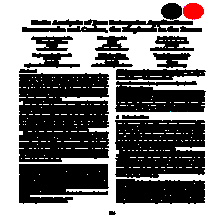

<Figure size 532.8x576 with 0 Axes>

In [111]:
inputDataNum = inputDataNum.astype(np.uint8)
fig = plt.figure()
fig.set_size_inches(7.4,8)
Image.fromarray(inputDataNum*255)
# plt.imshow()
# plt.show()

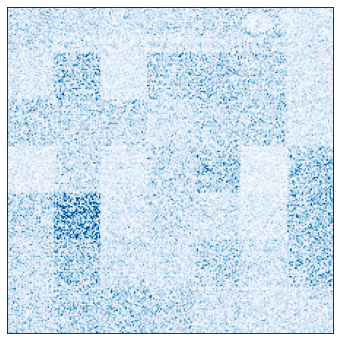

In [112]:
_ = visualization.visualize_image_attr(np.rollaxis(attributions.detach().numpy().squeeze(),0,3), np.rollaxis(inputData.detach().numpy(),0,3), method="heat_map", )
# plt.show()

## Saliency maps

In [37]:
inputData.shape

torch.Size([3, 224, 224])

In [38]:

# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
#net = ImageClassifier()
# Generating random input with size 2x3x3x32
input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Defining Saliency interpreter
saliency = Saliency(model1)
# Computes saliency maps for class 3.
attribution = saliency.attribute(inputData.unsqueeze(axis=0), target=3)

/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


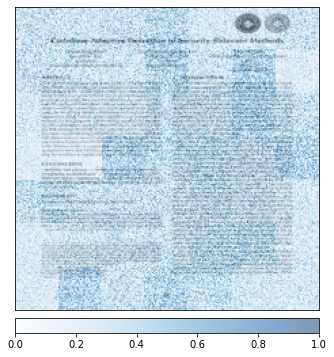

In [39]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

## DeepLift

In [32]:


# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
dl = DeepLift(model1)
# input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Computes deeplift attribution scores for class 3.
attribution = dl.attribute(inputData.unsqueeze(axis=0), target=3)

/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


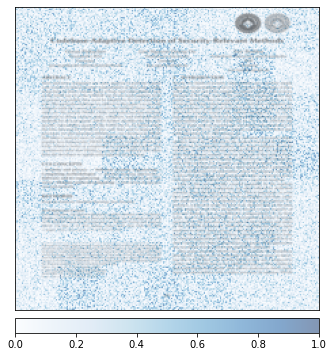

In [33]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

## DeepLiftSHAP

In [48]:
(inputData.unsqueeze(axis=0)*0).shape

torch.Size([1, 3, 224, 224])

In [51]:

# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
baseline = torch.rand(2,3,224,224)

dl = DeepLiftShap(model1)
# input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Computes deeplift attribution scores for class 3.
attribution = dl.attribute(inputData.unsqueeze(axis=0),baselines=baseline, target=0)

/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


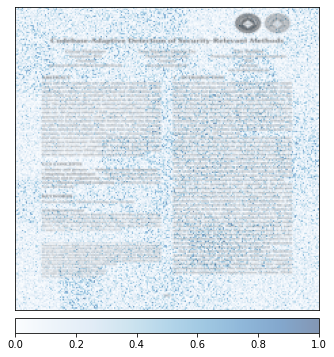

In [52]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

## GradientSHAP

In [61]:
# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
baseline = torch.rand(2,3,224,224)

gradient_shap = GradientShap(model1)
#input = torch.randn(3, 3, 224, 32, requires_grad=True)
# choosing baselines randomly
#baselines = torch.randn(20, 3, 32, 32)
# Computes gradient shap for the input
# Attribution size matches input size: 3x3x32x32
attribution = gradient_shap.attribute(inputData.unsqueeze(0), baseline,
                                                    target=5)

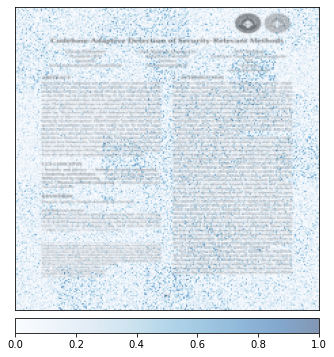

In [62]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

# All attributions

In [35]:

def visualize_attributions(inputData,attribution,figName):
    dataPoint = np.rollaxis(inputData.detach().numpy(),0,3)
    
    fig, axs = plt.subplots(1,2)
    ax1= axs[0]
    ax2 = axs[1]
    ax2.imshow(dataPoint)
    ax2.set_xticks([])
    ax2.set_yticks([])
    v = visualization.visualize_image_attr(attribution, 
                                       dataPoint,
                                       method="heat_map",
                                       show_colorbar = True,
                                    use_pyplot=True,
                                    plt_fig_axis = (fig,ax1))

    fig.savefig(figName)
    plt.show()    
    return v

def get_attribution(inputData, target, mode,model):
    models = {
    'integrated_gradients': IntegratedGradients,
    'saliency' : Saliency,
    'deep_lift' : DeepLift,
    'deep_lift_shap' : DeepLiftShap,
    'gradient_shap' : GradientShap,
    'input_x_gradient' : InputXGradient,
    'guided_backprop' : GuidedBackprop,
    'guided_gradcam' : GuidedGradCam,
    'deconvolution' : Deconvolution,
    'feature_ablation' : FeatureAblation,
    'occlusion': Occlusion
    }
    
    dataPoint = inputData.unsqueeze(0)
    
    model = models[mode](model)
    if mode=='occlusion':
        attribution = attr = model.attribute(dataPoint, target=target, sliding_window_shapes=(3,3))
        
    elif mode in ['deep_lift_shap','gradient_shap']:
        baseline = torch.rand(2,3,224,224)
        attribution = model.attribute(dataPoint, baseline,
                                                        target=target)
    else:
        attribution = model.attribute(dataPoint, target=target)
    
    return np.rollaxis(attribution.detach().numpy().squeeze(),0,3)


def load_input(nSample, train_data):
    inputData = train_data[nSample]#.detach().cpu()
    label = train_label[nSample]
    return inputData, label

def interpret_model(nSample, train_data, target, mode,model, figName):
    inputData, label = load_input(nSample, train_data)
    attribution = get_attribution(inputData, target, mode,model)
    vis = visualize_attributions(inputData, attribution, figName)
    

In [39]:
train_data, train_label= inputs, labels

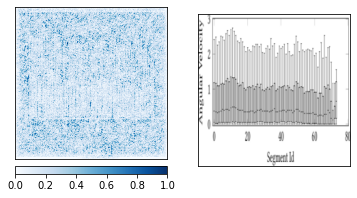

In [41]:
nsample = 31
interpret_model(nSample=nsample, 
                train_data=train_data,
                target=3,
                mode='integrated_gradients',
                model=net,
               figName="vesrt.png")

In [125]:
print(train_label[nsample])
train_label[np.take(train_label,3,axis=1)==1]

[0 1 0 1 0]


array([[0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0]])

In [220]:
np.take(train_label,3,axis=1)==1

array([False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False,  True,
       False, False, False, False, False, False,  True, False])

In [208]:
test_loader

# Insights

In [48]:
def formatted_data_iter():  
    # dataset = torchvision.datasets.CIFAR10(
    #     root="data/test", train=False, download=True, transform=transforms.ToTensor()
    # )
    # dataloader = iter(
    #     torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)
    # )
    while True:
        images, labels = next(iter(train_loader))
        
        yield Batch(inputs=images, labels=labels)

In [50]:
i,l = next(iter(train_loader))

torch.Size([64, 1, 9])

In [46]:


def baseline_func(input):
    return input*0

def full_img_transform(input):
    return input.unsqueeze(0)
    
visualizer = AttributionVisualizer(
            
            models = [model1],
            
            classes = list(dfLabels.drop(columns = 'fileName').columns),
            features = [
            ImageFeature(
                "Photo",
            baseline_transforms = [baseline_func],
            input_transforms= [full_img_transform])
            ],
            
            dataset = formatted_data_iter(),
)



In [47]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['Artifacts Available', 'Artifacts Evaluated & Functional', 'Artifa…

Output()

In [513]:
!conda install freetype=2.10.4

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - pytorch/noarch::captum==0.5.0=0
  - conda-forge/noarch::transformers==4.16.2=pyhd8ed1ab_0
  - pytorch/linux-64::torchvision==0.12.0=py310_cu102
  - pytorch/linux-64::torchaudio==0.11.0=py310_cu102
  - conda-forge/linux-64::pytorch==1.11.0=cpu_py310h2272b30_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/devesh/anaconda3/envs/reproducePy

  added / updated specs:
    - freetype=2.10.4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    freetype-2.10.4            |       h5ab3b9f_0         596 KB
    --------------------------------------------------

# Metrics

In [218]:
with torch.no_grad():
    
    for test_data, test_label in test_loader:
        #data = data#.to(device)
        #label = label#.to(device)

        test_output = model1(test_data)
        # val_loss = criterion(test_output, test_label)
        #print(val_output)

        #acc = (test_output.argmax(dim=1) == label).float().mean()
        #epoch_val_accuracy += acc / len(valid_loader)

        # acc = f1_score(label, output > 0.5)
        test_output = test_output.detach().numpy()
        test_label = test_label.detach().numpy().squeeze()
        print(test_output.shape, test_label.shape)
        
        # epoch_val_accuracy = compute_accuracy(val_output, val_label)
        # epoch_val_loss += val_loss / len(valid_loader)

(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(19, 9) (19, 9)


In [224]:
test_data.shape

torch.Size([19, 3, 224, 224])

# def compute_accuracy(output_fn, label_fn):
    accuracies = []
    for i in range(9):    
        print(output_fn.shape)
        outputSlice = np.take(output_fn,i, axis=1)>0.5#.shape
        outputSlice = score.astype(int)
        
        labelSlice = np.take(label_fn,i, axis=1)
        
#         print(outputSlice.shape)
#         print(outputSlice)
#         print(labelSlice.shape)
#         print(labelSlice)
        outputSlice = outputSlice[:len(labelSlice)]
        accuracies.append(accuracy_score(labelSlice, outputSlice))
    return accuracies